# Lab 1 - Part 1 - K-Nearest Neighbours

This lab is about the implementation and analysis of the KNN algorithm for classification and regression problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position wrt a linear separator.

The use of the function is the following:

**X, Y = linearBinaryClass(n, low_D, high_D, m, q)**

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)

In [2]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [3]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices. The usage is the following:

**D = allDistances(X1,X2)**
where
- **X1** is a matrix of size [n1xD], where each row is a D-dimensional point
- **X2** is a matrix of size [n2xD], where each row is a D-dimensional point
- **D** is a matrix of size [n1xn2], where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

In [4]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.

In [5]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

### The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. The use is as follow:

**_Ypred = kNNClassify(Xtr, Ytr, k, Xte)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

In [6]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = allDistances(Xte, Xtr)

    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)

    return Ypred

### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [7]:
def separatingFkNN(Xtr, Ytr, k):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

**_acc = calcAccuracy(Ypred, Ytrue)_**

where
- **Ypred** is an array of size [ntr], where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size [ntr], where each element is the true binary label
- **acc** is the fraction of correctly classified elements wrt the total number

Similarly we have the `calcError` function which returns the fraction of incorrectly classified samples

In [8]:
def calcAccuracy(Ypred, Ytrue):
    return (np.count_nonzero(Ypred == Ytrue)) / len(Ytrue)

def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Generate training and test sets, build and evaluate the KNN classifier

With K=1 the accuracy on the test set is  0.965
With K=1 the accuracy on the training set is  1.0


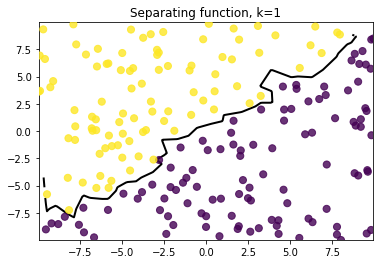

In [9]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the accuracy on the TEST SET
acc = calcAccuracy(Ypred, Yte)

print("With K=%d the accuracy on the test set is " % (k), acc)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
acctr = calcAccuracy(Ypredtr, Ytr)
print("With K=%d the accuracy on the training set is " % (k), acctr)

### Assignment 1

Keeping the parameters of the function and the number of points as in the previous example:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier first on the TRAINING and then on the TEST SET
- 5.Compute the obtained accuracy first on the TRAINING and then on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...


With K=1 the accuracy on the training set is  1.0
With K=1 the accuracy on the test set is  0.82


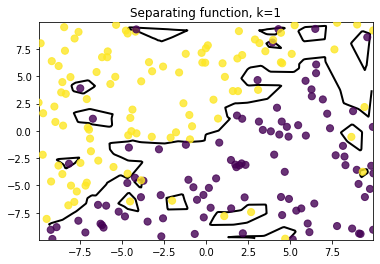

In [10]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
P = 10
Ytr = flipLabels(Ytr, P)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte = flipLabels(Yte, P)

# Evaluate the NN classifier on the TRAINING SET
Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
# Evaluate the NN classifier on the TEST SET
Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the accuracy on the TRAINING SET
acc_tr = calcAccuracy(Ypred_tr, Ytr)
print("With K=%d the accuracy on the training set is " % (k), acc_tr)

# Compute the accuracy on the TEST SET
acc_te = calcAccuracy(Ypred_te, Yte)
print("With K=%d the accuracy on the test set is " % (k), acc_te)


With K=5 the accuracy on the training set is  0.89
With K=5 the accuracy on the test set is  0.835


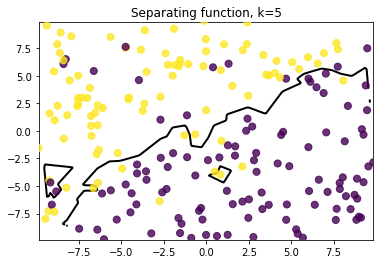

In [11]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 5

# Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
P = 10
Ytr = flipLabels(Ytr, P)

# Visualize the separating curve for the NN classifier 
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte = flipLabels(Yte, P)

# Evaluate the NN classifier on the TRAINING SET
Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
# Evaluate the NN classifier on the TEST SET
Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the accuracy on the TRAINING SET
acc_tr = calcAccuracy(Ypred_tr, Ytr)
print("With K=%d the accuracy on the training set is " % (k), acc_tr)

# Compute the accuracy on the TEST SET
acc_te = calcAccuracy(Ypred_te, Yte)
print("With K=%d the accuracy on the test set is " % (k), acc_te)


### Assignment 2

Analyse the performance of the **KNN** with plots, considering in particular the following:

- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING an TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

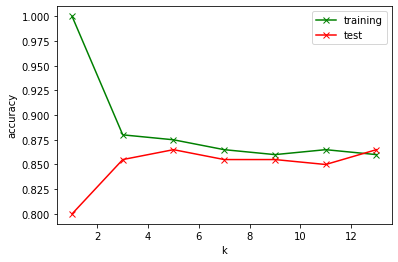

In [12]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

max_k = 15
acc_tr_k = {}
acc_te_k = {}


# Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
P = 10
Ytr = flipLabels(Ytr, P)

# Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)
Yte = flipLabels(Yte, P)

for k in range(1, max_k, 2):
    # Evaluate the NN classifier on the TRAINING SET
    Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
    # Evaluate the NN classifier on the TEST SET
    Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)

    # Compute the accuracy on the TRAINING SET
    acc_tr = calcAccuracy(Ypred_tr, Ytr)
    acc_tr_k[k] = acc_tr

    # Compute the accuracy on the TEST SET
    acc_te = calcAccuracy(Ypred_te, Yte)
    acc_te_k[k] = acc_te

plt.plot(acc_tr_k.keys(), acc_tr_k.values(), color='g', label="training", marker = "x")
plt.plot(acc_te_k.keys(), acc_te_k.values(), color='r', label="test", marker = "x")

plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()


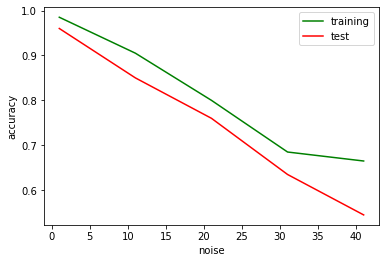

In [13]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 7 
acc_tr_k = {}
acc_te_k = {}


# Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

# Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

step = 10
max_noise = 50
for P in range(1, max_noise, step):
    Ytr_noise = flipLabels(Ytr, P)
    Yte_noise = flipLabels(Yte, P)


    # Evaluate the NN classifier on the TRAINING SET
    Ypred_tr = kNNClassify(Xtr, Ytr_noise, k, Xtr)
    # Evaluate the NN classifier on the TEST SET
    Ypred_te = kNNClassify(Xtr, Ytr_noise, k, Xte)

    # Compute the accuracy on the TRAINING SET
    acc_tr = calcAccuracy(Ypred_tr, Ytr_noise)
    acc_tr_k[P] = acc_tr

    # Compute the accuracy on the TEST SET
    acc_te = calcAccuracy(Ypred_te, Yte_noise)
    acc_te_k[P] = acc_te

plt.plot(acc_tr_k.keys(), acc_tr_k.values(), color='g', label="training")
plt.plot(acc_te_k.keys(), acc_te_k.values(), color='r', label="test")

plt.xlabel("noise")
plt.ylabel("accuracy")
plt.legend()

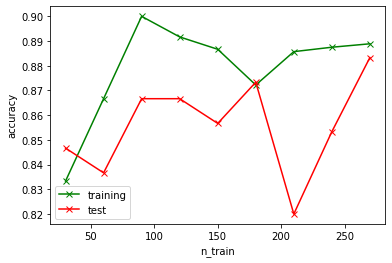

In [14]:
n_test = 300
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

P = 10
k = 7
acc_tr_k = {}
acc_te_k = {}


# Generate a test set WITH NOISE
Xte, Yte = linearBinaryClass(n_test, low_D, high_D, m, q)
Yte = flipLabels(Yte, P)

for n_train in range(30, 300, 30):
    # Generate a training set WITH NOISE
    Xtr, Ytr = linearBinaryClass(n_train, low_D, high_D, m, q)
    Ytr = flipLabels(Ytr, P)
    # Evaluate the NN classifier on the TRAINING SET
    Ypred_tr = kNNClassify(Xtr, Ytr, k, Xtr)
    # Evaluate the NN classifier on the TEST SET
    Ypred_te = kNNClassify(Xtr, Ytr, k, Xte)

    # Compute the accuracy on the TRAINING SET
    acc_tr = calcAccuracy(Ypred_tr, Ytr)
    acc_tr_k[n_train] = acc_tr

    # Compute the accuracy on the TEST SET
    acc_te = calcAccuracy(Ypred_te, Yte)
    acc_te_k[n_train] = acc_te

plt.plot(acc_tr_k.keys(), acc_tr_k.values(), color='g', label="training", marker = "x")
plt.plot(acc_te_k.keys(), acc_te_k.values(), color='r', label="test", marker = "x")

plt.xlabel("n_train")
plt.ylabel("accuracy")
plt.legend()


# Part 2 - Cross Validation for KNN

So far you experienced how the use of different possible values of K may influence the results, also depending on the type of data, their cardinality, and the amount of noise.

**We now apply Cross Validation for the choice of an appropriate value for the parameter K.**

### Compute the test error for different values of K

Having access to both the training and the test, we may start by having a look at the trend of the test error as the value of K increases. To this purpose we use the function

**_train_err, test_err = trainTestAnalysis(k_list, Xtr, Ytr, Xte, Yte)_**

where
- **k_list**: array of possible values for K to be considered
- **Xtr** and **Ytr**: respectively, input and output of the training set
- **Xts** and **Yts**: respectively, input and output of the test set
- **train_err**, **test_err**: array of errors on training and test for different values of K

In [15]:
def trainTestAnalysis(k_list, Xtr, Ytr, Xte, Yte):
    train_err = np.zeros(len(k_list))
    test_err = np.zeros(len(k_list))

    for kdx, k in enumerate(k_list):
        Ypredte = kNNClassify(Xtr, Ytr, k, Xte)
        test_err[kdx] = calcError(Ypredte, Yte)
        
        Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
        train_err[kdx] = calcError(Ypredtr, Ytr)

    return train_err, test_err

### K-Fold Cross Validation

For K-fold cross-validation we use the following function:


**_best_k, Vm, Vs, Tm, Ts = KFoldCVkNN(Xtr, Ytr, KF, k_list)_**

where
- **Xtr** and **Ytr** are respectively, input and output of the training set
- **KF**: number of folds
- **k_list**:  array of possible values for K to be considered

and the returned values are:
- **best_k**: the value in k_list that minimizes the mean of the validation error
- **Vm** and **Vs**: mean and variance of the validation error for each value of the parameter
- **Tm** and **Ts**: mean and variance of the training error for each value of the parameter

In [16]:
def KFoldCVkNN(Xtr, Ytr, KF, k_list):
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = k_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, KF))
    val_errors = np.zeros((num_k, KF))

    for kdx, k in enumerate(k_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            X = Xtr[~val_mask]
            Y = Ytr[~val_mask]
            X_val = Xtr[val_mask]
            Y_val = Ytr[val_mask]
            
            # Compute the training error of the kNN classifier for the given value of k
            tr_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X), Y)

            # Compute the validation error of the kNN classifier for the given value of k
            val_errors[kdx, fold] = calcError(kNNClassify(X, Y, k, X_val), Y_val)

    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)

    best_k_idx = np.argmin(val_mean)
    best_k = k_list[best_k_idx]

    return best_k, val_mean, val_var, tr_mean, tr_var

### Trying model selection with different strategies

It is now time to try and compare different strategies for selecting the best value for the parameter K. To this purpose we provide you some example datasets for binary classification problems (see Material.zip) you can play with. 

The datasets have the following properties:
- (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
- (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
- (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
- (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

To load a dataset (e.g. Training1/Test1) use the following:    

In [17]:
with open("Material/Training1.dat","rb") as f:
    [Xtr, Ytr] = pickle.load(f)
with open("Material/Test1.dat","rb") as f:
    [Xte, Yte] = pickle.load(f)

### To plot the results of cross-validation you may use the following function. It expects as inputs the list of values of k which were tested, and training and validation errors with their respective variance.

As an example usage, you could run:
```python
k_list = [1, 2, 3]
best_k, val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, 5, k_list)
plot_knn_errors(k_list, val_err, val_var, tr_err, tr_var)
```

In [18]:
def plot_knn_errors(k_list, val_mean, val_var, tr_mean, tr_var):
    fig, ax = plt.subplots()
    ax.errorbar(k_list, val_mean, val_var, label="Validation eror")
    ax.errorbar(k_list, tr_mean, tr_var, label="Training error")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Only show integer labels on x-axis
    ax.legend(loc="best")
    ax.set_ylabel("Error (misclassified fraction)")
    ax.set_xlabel("K")

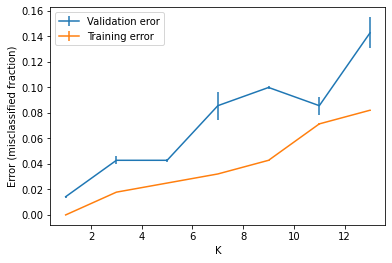

In [19]:
k_list = np.arange(1, 15, 2)
best_k, val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, 5, k_list) #type:ignore
plot_knn_errors(k_list, val_err, val_var, tr_err, tr_var)

In [20]:
[train_err, test_err] = trainTestAnalysis(np.arange(1, 15, 2), Xtr, Ytr, Xte, Yte)

Text(0.5, 0, 'K')

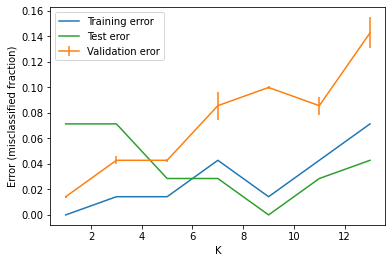

In [21]:
# Let's plot training, test and validation errors in the same plot

fig, ax = plt.subplots()
ax.plot(k_list, train_err, label="Training error")
ax.errorbar(k_list, val_err, val_var, label="Validation eror")
ax.plot(k_list, test_err, label="Test eror")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Only show integer labels on x-axis
ax.legend(loc="best")
ax.set_ylabel("Error (misclassified fraction)")
ax.set_xlabel("K")

### To go deeper:
1. Run k-fold CV for different numbers of folds.
   - Compare the optimal `k` as given by cross-validation with the best `k` on the test dataset (you can get this with the `trainTestAnalysis` function). _Use the noise-less datasets for clearer results._
2. Compare results on the noisy, and noise-less datasets:
    - How does the optimal `k` change as the noise is increased?

In [49]:
# Function that plots the optimal_ks and a constant best_k in order to compare them 
def plot_optimal_k_compare_best_k(n_folds, optimal_ks, best_k):
    max_y = max(best_k, max(optimal_ks)) + 1
    fig,ax = plt.subplots()
    plt.plot(n_folds, optimal_ks, label = "optimal_ks", color = "g", marker = 'x')
    plt.hlines(y=best_k, xmin=n_folds[0], xmax=n_folds[-1], color='b', linestyle='-', label="best_k")
    plt.ylim(0, max_y)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xticks(n_folds)
    ax.set_yticks(np.append(list(optimal_ks), best_k))

k is greater than the number of points, setting k=n_train
k is greater than the number of points, setting k=n_train
k is greater than the number of points, setting k=n_train
k is greater than the number of points, setting k=n_train


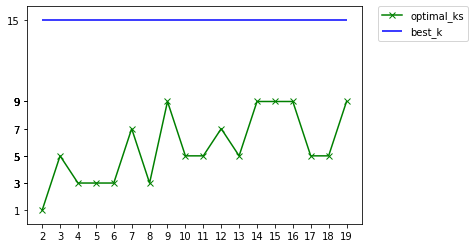

In [50]:
with open("Material/Training2.dat","rb") as f:
    [Xtr, Ytr] = pickle.load(f)
with open("Material/Test2.dat","rb") as f:
    [Xte, Yte] = pickle.load(f)

k_list = np.arange(1, 23, 2)
n_folds = np.arange(2, 20)
optimal_ks = {}

[train_err, test_err] = trainTestAnalysis(k_list, Xtr, Ytr, Xte, Yte)
best_k = k_list[np.argmin(test_err)]

for folds in n_folds:
    optimal_ks[folds], val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, folds, k_list) #type: ignore

plot_optimal_k_compare_best_k(n_folds, optimal_ks.values(), best_k)

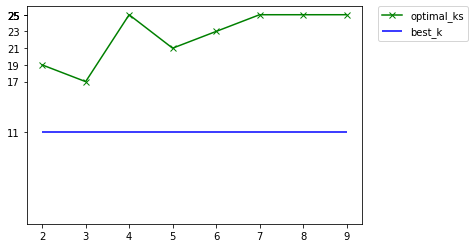

In [51]:
with open("Material/Training3.dat","rb") as f:
    [Xtr, Ytr] = pickle.load(f)
with open("Material/Test3.dat","rb") as f:
    [Xte, Yte] = pickle.load(f)

k_list = np.arange(1, 31, 2)
n_folds = np.arange(2, 10)
optimal_ks = {}

[train_err, test_err] = trainTestAnalysis(k_list, Xtr, Ytr, Xte, Yte)
best_k = k_list[np.argmin(test_err)]

for folds in n_folds:
    optimal_ks[folds], val_err, val_var, tr_err, tr_var = KFoldCVkNN(Xtr, Ytr, folds, k_list) #type: ignore

plot_optimal_k_compare_best_k(n_folds, optimal_ks.values(), best_k)

# Comments

We can notice that as the noise increases, the optimal value of `k` increases as well. This is because the noise makes the data less reliable, and so we need to consider more neighbours to get a more robust estimate of the class of a point, in fact in contrast to what we can see that in the case where the noise is absent, the values of optimal k are small. In addition to that, in the noise-less case we can notice that all the optimal values of k are lesser than or equal to the value of best k while in the noisy case it's the contrary.